In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

import seaborn as sns
from utils.colors import DTU_COLOR_HEX, DTU_BIN, DTU_BIN_HC
colors = list(DTU_COLOR_HEX.values())
sns.set_palette(sns.color_palette(colors))
CM_DTU_BIN = LinearSegmentedColormap.from_list('dtu_bin', DTU_BIN, N=2)
import pickle

from models.daypattern import DayPatternSim, ACTIVITIES
from models.prim import PrimClassifier, score, coverage, density
from models.sampler import Sampler
from utils.data_loader import load_metadata, load_betas

%matplotlib inline

In [2]:
ACTIVITY = 'LeisureT'
THRESHOLD = 7900

betas_dp = load_betas('dp')
names = list(betas_dp.keys())[:-1]

In [3]:
df, betas, bounds = load_metadata()
data = pd.read_csv(f'data/out/LHS/1685970373.084523.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data_standardized = (data - data.mean()) / data.std()
cube_lhs = data[names]
counts_lhs = data[ACTIVITY]

In [4]:
filename = 'pb_100'

data = pd.read_csv(f'data/out/PB/{filename}.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data_standardized = (data - data.mean()) / data.std()
cube_pb = data[names]
counts_pb = data[ACTIVITY]

In [5]:
filename = 'qd_100'

data = pd.read_csv(f'data/out/QD/{filename}.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data_standardized = (data - data.mean()) / data.std()
cube_me = data[names]
counts_me = data[ACTIVITY]

In [6]:
filename = 'ax_ei_100'

data = pd.read_csv(f'data/out/BO/{filename}.csv')
data = data.drop(['Unnamed: 0'], axis=1)
# data_standardized = (data - data.mean()) / data.std()
cube_bo = data[names]
counts_bo = data[ACTIVITY]

In [7]:
BEST = max(counts_me.max(), counts_lhs.max(), counts_pb.max(), counts_bo.max())
BEST

8541.0

In [8]:
perf_bo = (counts_bo.iloc[1000:] / BEST).values
perf_bo

array([0.94614214, 0.94391757, 0.96171409, 0.95316708, 0.95246458,
       0.96417281, 0.94087343, 0.92413066, 0.95796745, 0.95269875,
       0.92014987, 0.95164501, 0.92928229, 0.95492331, 0.92904812,
       0.96897319, 0.96136284, 0.95679663, 0.94520548, 0.95703079,
       0.95304999, 0.97178316, 0.95070835, 0.96007493, 0.9655778 ,
       0.9556258 , 0.96581197, 0.943098  , 0.96604613, 0.92026695,
       0.95925536, 0.96066034, 0.95667955, 0.95304999, 0.94087343,
       0.96311907, 0.94052219, 0.9503571 , 0.95843578, 0.95281583,
       0.93619014, 0.93794638, 0.94614214, 0.92998478, 0.93935136,
       0.97037818, 0.95070835, 0.96265074, 0.97236858, 0.961597  ,
       0.96241658, 0.92928229, 0.96534364, 0.95410373, 0.96101159,
       0.95141084, 0.95386957, 0.91897904, 0.9411076 , 0.94672755,
       0.96745112, 0.94567381, 0.961597  , 0.95515748, 0.94930336,
       0.97026109, 0.97307107, 0.94204426, 0.94497131, 0.96452406,
       0.94743004, 0.89848964, 0.96791945, 0.96592905, 0.95316

In [9]:
boxplot_df_perf = pd.DataFrame({
    'LHS': (counts_lhs.sample(1100) / BEST).values,
    'PB': (counts_pb.iloc[100:1200] / BEST).values,
    'BO': (counts_bo.iloc[100:1200] / BEST).values,
    'ME': (counts_me.iloc[100:1200] / BEST).values, 
})


Text(0, 0.5, 'Global perforamce')

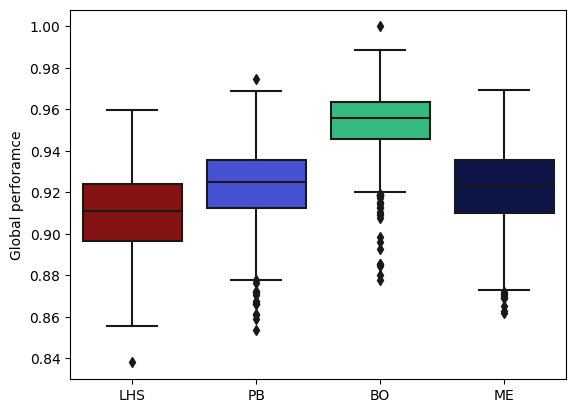

In [10]:
## Global performance

sns.boxplot(boxplot_df_perf)
plt.ylabel('Global perforamce')

In [11]:
from sklearn.cluster import KMeans
N_CLUSTERS = 64
km = KMeans(n_clusters=N_CLUSTERS)
km.fit(cube_lhs)

/home/s212815/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=64)

In [18]:
def get_best_values(cube, counts):
    clusters = km.predict(cube)
    best_index = np.empty(N_CLUSTERS)
    best_values = np.empty(N_CLUSTERS)
    for k in range(N_CLUSTERS):
        mask = clusters == k
        try:
            best_index[k] = counts.iloc[mask].idxmax()
        except:
            best_index[k] = -1

    best_index = best_index.astype(int)
    for k in range(N_CLUSTERS):
        if best_index[k] == -1:
            best_values[k] = 0
        else:
            best_values[k] = counts.iloc[best_index[k]]
    return best_index, best_values, clusters

In [20]:
best_index_lhs, best_values_lhs, clusters_lhs = get_best_values(cube_lhs, counts_lhs)
best_index_pb, best_values_pb, clusters_pb = get_best_values(cube_pb, counts_pb)
best_index_bo, best_values_bo, clusters_bo = get_best_values(cube_bo, counts_bo)
best_index_me, best_values_me, clusters_me = get_best_values(cube_me, counts_me)

In [21]:
boxplot_df_reliability = pd.DataFrame({
    'LHS': (best_values_lhs / BEST),
    'PB': (best_values_pb / BEST),
    'BO': (best_values_bo / BEST),
    'ME': (best_values_me / BEST), 
})


Text(0, 0.5, 'Global reliability')

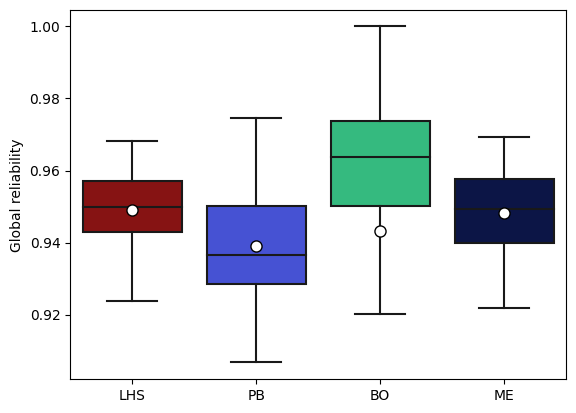

In [22]:
## Global reliability

sns.boxplot(boxplot_df_reliability, showfliers = False, showmeans=True, meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
plt.ylabel('Global reliability')

In [23]:
precision_bo = [counts_bo.iloc[i]/ best_values_bo[clusters_bo[i]] for i in range(len(cube_bo))]

In [25]:
boxplot_df_precision = pd.DataFrame({
    'LHS': [counts_lhs.iloc[i]/ best_values_lhs[clusters_lhs[i]] for i in range(1100)],
    'PB': [counts_pb.iloc[i]/ best_values_pb[clusters_pb[i]] for i in range(1100)],
    'BO': precision_bo[:1100],
    'ME': [counts_me.iloc[i]/ best_values_me[clusters_me[i]] for i in range(1100)],    
})

<Axes: >

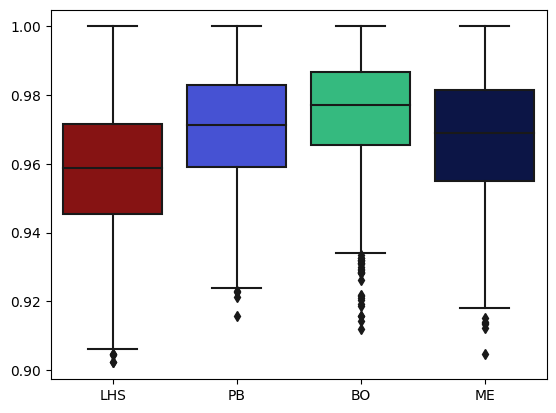

In [26]:
## Global precision

sns.boxplot(boxplot_df_precision)